In [2]:
import scipy.signal
import torch
from src.utils.fourier import dft, idft
import matplotlib.pyplot as plt
import scipy
import numpy as np
# from src.utils.filters import MovingAvg
from src.utils.fourier import sphere2complex, complex2sphere

# def moving_average_freq_response(N, sample_rate, freq):
#     omega = 2 * torch.pi * freq / sample_rate
#     # SMA coefficients
#     b = np.ones(N)
#     a = np.array([N] + [0]*(N-1))

#     # Calculate the frequency response
#     w, h = scipy.signal.freqz(b, a, worN=omega)
#     # w *= sample_rate / (2 * np.pi)                      # Convert from rad/sample to Hz
#     return h

def moving_average_freq_response(N, sample_rate, freq):
    omega = 2 * torch.pi * freq / sample_rate
    coeff = torch.exp(-1j * omega * (N - 1) / 2) / N
    omega = torch.where(omega == 0, 1e-5, omega)
    Hw = coeff * torch.sin(omega * N / 2) / torch.sin(omega / 2)
    # Hw = Hw*torch.exp(1j*omega*N)
    return Hw

# def moving_avg(x, N):
#     avg = torch.nn.AvgPool1d(kernel_size=N, stride=1)
#     front = x[:, 0:1, :].repeat(1, N // 2, 1)
#     end = x[:, -1:, :].repeat(1, N - 1 - N // 2, 1)
#     x = torch.cat([front, x, end], dim=1)
#     x = avg(x.permute(0, 2, 1))
#     x = x.permute(0, 2, 1)
#     return x



original signal

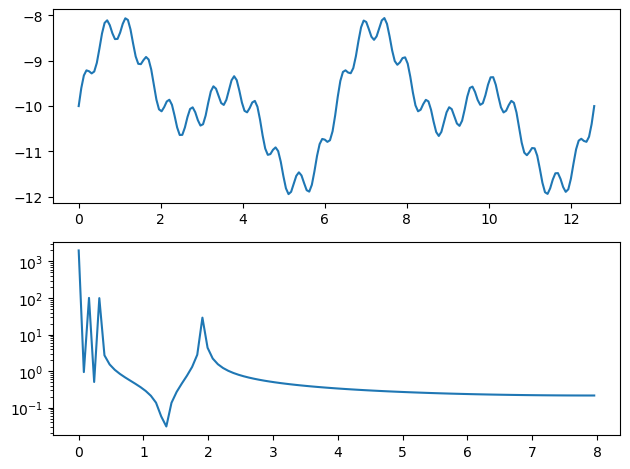

In [22]:
t = torch.linspace(0, 4*torch.pi, 200)
sample_rate = len(t)/(t.max()-t.min())
x = torch.sin(t) + torch.sin(2*t) + 0.3*torch.sin(12*t) - 10
x_freq = torch.fft.rfft(x)

theta, phi = complex2sphere(x_freq.real, x_freq.imag)

freq = torch.fft.rfftfreq(len(t), 1/sample_rate)
mag = x_freq.abs()
phase = x_freq.angle()
phase[torch.abs(phase) < 1] = 0
fig, axs = plt.subplots(2)
axs[0].plot(t, x)
axs[1].plot(freq, x_freq.abs())
axs[1].set_yscale('log')
# axs[1].set_xscale('log')
# axs[2].plot(freq, x_freq.angle())
# axs[1].plot(freq, theta)
# axs[2].plot(freq, phi)
fig.tight_layout()



manuplate on the frequency domain

IndexError: index 2 is out of bounds for axis 0 with size 2

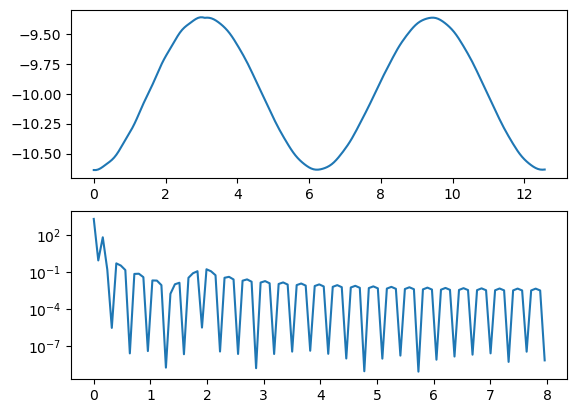

In [20]:
N = 50
h = moving_average_freq_response(N, sample_rate=sample_rate, freq=freq)
x_freq_new = x_freq * h
# x_freq_new = x_freq * h * torch.exp(torch.tensor(-1j*N))
mag = x_freq_new.abs()
phase = x_freq_new.angle()
x_new = torch.fft.irfft(x_freq_new)
x_new_avgpool = torch.nn.functional.avg_pool1d(x.reshape(1,1,-1), N,N).permute(0,2,1)
fig, axs = plt.subplots(2)
# axs[0].plot(x_new)
axs[0].plot(t, x_new)
# axs[0].scatter(t[N-1::N],x_new[N-1::N])
# axs[0].scatter(t[N-1::N], x_new_avgpool.flatten())
axs[1].plot(freq, mag)
axs[1].set_yscale('log')
# axs[1].set_xscale('log')
# axs[2].plot(freq, phase)

manuplate on the time domain

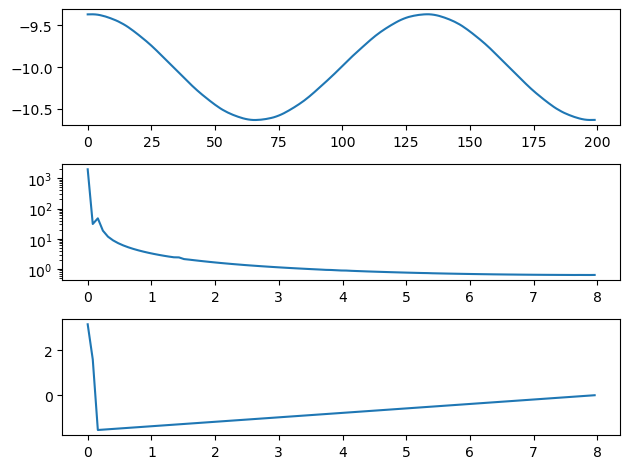

In [23]:
from src.utils.filters import MovingAvgTime


x_new = MovingAvgTime(N)(x.reshape(1,-1,1))
# x_new = np.convolve(np.concatenate([x[-N+1:],x]), np.ones(N)/N, mode='valid')
x_freq = torch.fft.rfft(x_new.flatten())
freq = torch.fft.rfftfreq(len(t), 1/sample_rate)
mag = x_freq.abs()
phase = x_freq.angle()

# mag = x_freq_new.abs()
# phase = x_freq_new.angle()
# # print(phase)
# x = torch.fft.irfft(x_freq_new)
# print(x_new[N//2:-N//2])
fig, axs = plt.subplots(3)
axs[0].plot(x_new.flatten())
axs[1].plot(freq, mag)
axs[1].set_yscale('log')
# axs[1].set_xscale('log')
axs[2].plot(freq, phase)
fig.tight_layout()

In [12]:
class FreqLinear(torch.nn.Module):
    def __init__(self, in_channels, fft_len, kernal_size) -> None:
        super().__init__()
        self.kernel = torch.nn.Parameter(
            torch.complex(
                torch.ones(fft_len, kernal_size), torch.zeros(fft_len, kernal_size)
            ),
            requires_grad=True,
        )
        self.linear = torch.nn.Linear(kernal_size * in_channels , in_channels).to(torch.cfloat)
        self.in_channels= in_channels
        self.fft_len = fft_len
        
    def forward(self, x):
        # x = x.permute(0,2,1)
        x = torch.fft.rfft(x, norm="ortho", dim=1)
        x_channels = []
        for i in range(x.shape[-1]):
            x_channels.append(x[...,[i]] * self.kernel)
        x = torch.concat(x_channels, dim=-1)
        x = self.linear(x)
        # x = self.linear(x.flatten()).reshape(-1, self.fft_len, self.in_channels)
        x = torch.fft.irfft(x, norm="ortho", dim=1)
        return x


class TimeConv(torch.nn.Module):
    def __init__(self, in_channel) -> None:
        super().__init__()
        self.conv = torch.nn.Conv1d(
            in_channel, out_channels=in_channel, kernel_size=3, bias=False, padding=1
        )

    def forward(self, x):
        # x = x.permute(0,2,1)
        x = self.conv(x)
        return x


x = torch.sin(torch.arange(288) / 100).reshape(1, -1, 2)
m = FreqLinear(in_channels=x.shape[-1], fft_len=x.shape[1]//2+1, kernal_size=10)
for p in m.parameters():
    print(p.numel())
y = torch.ones_like(x)
loss_fn = torch.nn.MSELoss()
loss = loss_fn(y, m(x))
loss.backward()

# x = x.repeat(2,1,1)
# kernel = torch.rand(x.shape[1] // 2 + 1, 3)
# x = torch.fft.rfft(x, dim=1)
# print(x)
# print(kernel)
# print(x.shape)
# print(kernel.shape)
# x * kernel

730
40
2
torch.Size([1, 73, 2])
torch.Size([73, 10])
torch.Size([1, 73, 20])


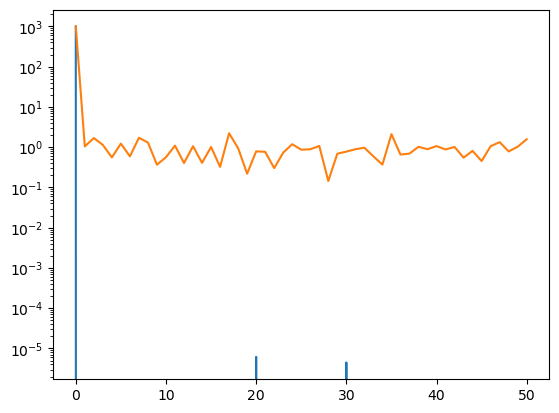

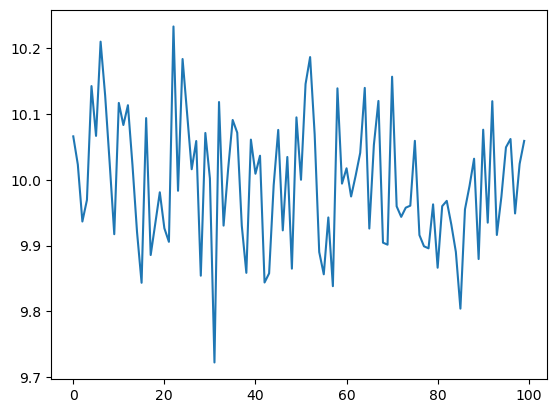

In [56]:
import torch
x = torch.ones(100) * 10
# x = torch.randn(1000)
# x = torch.sin(torch.arange(314 * 4) / 100)
x_fft = torch.fft.rfft(x)
plt.plot(x_fft.abs())
plt.yscale("log")
x_fft = x_fft + torch.randn_like(x_fft,dtype=torch.cfloat)
# plt.xscale("log")
plt.plot(x_fft.abs())

fig = plt.figure()
x = torch.fft.irfft(x_fft)
plt.plot(x)

In [25]:
import torch
def moving_average_1d(data: torch.Tensor, kernel_size:int, stride:int=1):
    # Unfold the data tensor to create a windowed view
    unfolded_data = data.unfold(1, kernel_size, stride)
    print(unfolded_data.shape)
    
    # Create a kernel tensor for matrix multiplication
    kernel = torch.ones(kernel_size) / kernel_size
    
    # Perform matrix multiplication
    moving_averages_unfolded = unfolded_data @ kernel
    
    # # Pad the moving averages tensor to match the original data size
    # padding = kernel_size - 1
    # moving_averages_padded = torch.cat((torch.zeros(padding), moving_averages_unfolded))
    
    # Fold the moving averages tensor to get the final result
    # moving_averages = moving_averages_padded.view(-1)
    
    return moving_averages_unfolded

# Example usage
data = torch.arange(60).float().reshape(2,-1,3)  # 1D tensor with 10 elements
kernel_size = 5

moving_averages = moving_average_1d(data, kernel_size)
print(moving_averages)  # Output: torch.Size([10])

torch.Size([2, 6, 3, 5])
tensor([[[ 6.0000,  7.0000,  8.0000],
         [ 9.0000, 10.0000, 11.0000],
         [12.0000, 13.0000, 14.0000],
         [15.0000, 16.0000, 17.0000],
         [18.0000, 19.0000, 20.0000],
         [21.0000, 22.0000, 23.0000]],

        [[36.0000, 37.0000, 38.0000],
         [39.0000, 40.0000, 41.0000],
         [42.0000, 43.0000, 44.0000],
         [45.0000, 46.0000, 47.0000],
         [48.0000, 49.0000, 50.0000],
         [51.0000, 52.0000, 53.0000]]])


In [97]:
import torch
import matplotlib.pyplot as plt
from scipy.stats import norm
from src.utils.filters import MovingAvgFreq

a = torch.ones(10000) * 10
torch.fft.rfft(a, norm='ortho')

tensor([1000.+0.j,    0.+0.j,    0.+0.j,  ...,    0.+0.j,    0.+0.j,    0.+0.j])

In [94]:
import torch

a = torch.randn(32,100,1, dtype=torch.cfloat).cuda()
b = torch.randn(32,100,1, dtype=torch.cfloat).cuda()
print((torch.abs(a-b)**2).sum())

a = torch.fft.irfft(a, dim=1, norm='ortho')
b = torch.fft.irfft(b, dim=1, norm='ortho')
print((torch.abs(a-b)**2).sum())
# print(torch.abs(a-b).sum())


a = torch.randn(32,100,1).cuda()
b = torch.randn(32,100,1).cuda()
# print((torch.abs(a-b)).sum())
print(torch.norm(a-b)**2)
print(torch.nn.functional.mse_loss(a,b)*3200)

a = torch.fft.fft(a, dim=1, norm='ortho')
b = torch.fft.fft(b, dim=1, norm='ortho')
print((torch.norm(a-b)**2))
# print(torch.abs(a-b).sum())

tensor(6511.7324, device='cuda:0')
tensor(12786.3291, device='cuda:0')
tensor(6121.7505, device='cuda:0')
tensor(6121.7500, device='cuda:0')
tensor(6121.7515, device='cuda:0')


In [5]:
import torch
from scipy.stats import norm

a = torch.randn(1000000)
b = torch.randn(1000000, dtype=torch.cfloat)
print(norm.fit(a))
print(norm.fit(b.real))
print(norm.fit(b.imag))


(-0.0012351502, 1.0012932)
(0.00045547247, 0.7068799)
(-0.0012430035, 0.7072186)
